In [82]:
import cv2
import math
import argparse
import shutil, os
import matplotlib.pyplot as plt
import pandas as pd
from itertools import chain

def highlightFace(net, frame, conf_threshold=0.7):
    frameOpencvDnn=frame.copy()
    frameHeight=frameOpencvDnn.shape[0]
    frameWidth=frameOpencvDnn.shape[1]
    blob=cv2.dnn.blobFromImage(frameOpencvDnn, 1.0, (300, 300), [104, 117, 123], True, False)

    net.setInput(blob)
    detections=net.forward()
    faceBoxes=[]
    for i in range(detections.shape[2]):
        confidence=detections[0,0,i,2]
        if confidence>conf_threshold:
            x1=int(detections[0,0,i,3]*frameWidth)
            y1=int(detections[0,0,i,4]*frameHeight)
            x2=int(detections[0,0,i,5]*frameWidth)
            y2=int(detections[0,0,i,6]*frameHeight)
            faceBoxes.append([x1,y1,x2,y2])
            cv2.rectangle(frameOpencvDnn, (x1,y1), (x2,y2), (0,255,0), int(round(frameHeight/150)), 8)
    return frameOpencvDnn,faceBoxes


In [12]:

faceProto="opencv_face_detector.pbtxt"
faceModel="opencv_face_detector_uint8.pb"
ageProto="age_deploy.prototxt"
ageModel="age_net.caffemodel"
genderProto="gender_deploy.prototxt"
genderModel="gender_net.caffemodel"

MODEL_MEAN_VALUES=(78.4263377603, 87.7689143744, 114.895847746)
ageList=['(0-2)', '(4-6)', '(8-12)', '(15-20)', '(25-32)', '(38-43)', '(48-53)', '(60-100)']
genderList=['Male','Female']

faceNet=cv2.dnn.readNet(faceModel,faceProto)
ageNet=cv2.dnn.readNet(ageModel,ageProto)
genderNet=cv2.dnn.readNet(genderModel,genderProto)

In [55]:
def get_age_range(age):
    age_dict = {'age1' : ['(0-2)', '(4-6)', '(8-12)', '(15-20)', '(25-32)'],
                'age2' : ['(38-43)', '(48-53)'],
                'age3' : ['(60-100)']}
    
    if age in age_dict.get('age1'):
        age = 'age1'
    elif age in age_dict.get('age2'):
        age = 'age2'
    elif age in age_dict.get('age3'):
        age = 'age3'
    return age

def rgb_to_bgr(image):
    image_ = cv2.imread(image)
    b, g, r = cv2.split(image_)
    image_ = cv2.merge([r, g, b])
    return image_


In [14]:
folder_dir = '/opt/ml/input/data_re/train/re_images/dir_test'  # 경로를 넣어주세요
folder_name = os.listdir(folder_dir)

file_list = [[folder_name[i]+"/"+file for file in os.listdir(os.path.join(folder_dir,folder_name[i])) if '._' not in file and 'ipynb' not in file] for i in range(len(folder_name))]

# 모든 이미지명 리스트
all_file_list = list(chain(*file_list))

# class별 이미지명 리스트
incorrect_img = file_list[0]
normal_img = file_list[1]
mask_img = file_list[2]

print('모든 이미지 수: ', len(all_file_list))
print('{} class 이미지 수:'.format(folder_name[0]), len(incorrect_img))
print('{} class 이미지 수:'.format(folder_name[1]), len(normal_img))
print('{} class 이미지 수:'.format(folder_name[2]), len(mask_img))

모든 이미지 수:  18900
incorrect class 이미지 수: 2700
normal class 이미지 수: 2700
mask class 이미지 수: 13500


In [76]:
# 이미지 파일
image = os.path.join(folder_dir, normal_img[332])
image

'/opt/ml/input/data_re/train/re_images/dir_test/normal/006368_male_Asian_age1_19_normal.jpg'

In [93]:
data_all_df = pd.DataFrame({}, columns=['file_name', 'id', 'age', 'age_group','age_group_pred','age_pred', 'gender', 'gender_pred'])
error = []

for file in normal_img:
    image = os.path.join(folder_dir, file)
    
    frame = cv2.imread(image) # image 
    gender, age = 'None', 'None'  # gender, age 초기화

    file_name = image.split('/')[-1] # file_name
    id_, gender_, race_, age_group_, age_, type_ = file_name.split('_')   # 실제 데이터의 정보

    padding=20

    resultImg,faceBoxes=highlightFace(faceNet,frame)
    if not faceBoxes:
        print("No face detected")

    try:
        for faceBox in faceBoxes:
            face=frame[max(0,faceBox[1]-padding):
                        min(faceBox[3]+padding,frame.shape[0]-1),max(0,faceBox[0]-padding)
                        :min(faceBox[2]+padding, frame.shape[1]-1)]

            blob=cv2.dnn.blobFromImage(face, 1.0, (227,227), MODEL_MEAN_VALUES, swapRB=False)
            genderNet.setInput(blob)
            genderPreds=genderNet.forward()
            gender=genderList[genderPreds[0].argmax()].lower()

            ageNet.setInput(blob)
            agePreds=ageNet.forward()
            age=ageList[agePreds[0].argmax()]
            age_group = get_age_range(age)
        
        flash_data = [file_name, id_, age_, age_group_, age_group, age, gender_, gender]
        data_all_df = data_all_df.append(pd.Series(flash_data, index=data_all_df.columns), ignore_index=True)
    except:
        print("Can't detect face")    
        error.append(file_name)
    # print(gender, age)


Can't detect face
Can't detect face
Can't detect face


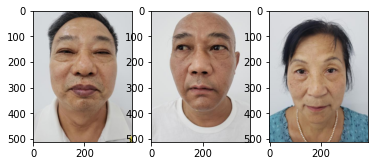

In [ ]:
# check error -> 얼굴 인식을 못하는 경우!
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

image = os.path.join(folder_dir, "normal/"+error[0])
img2 = rgb_to_bgr(image)
ax1.imshow(img2)

image = os.path.join(folder_dir, "normal/"+error[1])
img2 = rgb_to_bgr(image)
ax2.imshow(img2)

image = os.path.join(folder_dir, "normal/"+error[2])
img2 = rgb_to_bgr(image)
ax3.imshow(img2)

plt.show()

In [133]:
# data_all_df.to_csv('age_gender_detection_normal.csv', index=False)

In [134]:
age_check = data_all_df['age_group'] == data_all_df['age_group_pred']
gender_check = data_all_df['gender'] == data_all_df['gender_pred']

data_all_df['check_age'] = age_check.apply(lambda x:'incorrect_age' if x == False else 'correct_age')
data_all_df['check_gender'] = gender_check.apply(lambda x:'incorrect_gender' if x == False else 'correct_gender')

In [141]:
data_all_df['check_age'].value_counts()

correct_age      1598
incorrect_age    1099
Name: check_age, dtype: int64

In [142]:
data_all_df['check_gender'].value_counts()

correct_gender      1826
incorrect_gender     871
Name: check_gender, dtype: int64

In [113]:
img = os.path.join(folder_dir, normal_img[0])
img = rgb_to_bgr(img)
# img = cv2.imread(img)


In [111]:
img = os.path.join(folder_dir, "normal/"+error[0])
# img = cv2.imread(img)
img

(512, 384, 3)

In [68]:
age=ageList[agePreds[0].argmax()]
age_pred = max(agePreds[0].round(3))
age_group = get_age_range(age)
print(age, age_pred, age_group)

(8-12) 0.846 age1


In [69]:
for i in range(len(ageList)):
    print(ageList[i]," : ", agePreds[0][i].round(3))

(0-2)  :  0.0
(4-6)  :  0.005
(8-12)  :  0.846
(15-20)  :  0.124
(25-32)  :  0.01
(38-43)  :  0.014
(48-53)  :  0.0
(60-100)  :  0.0


In [81]:
data_all_df = pd.DataFrame({},columns=['file_name', 'id', 'age', 'age_group','age_group_pred','age_pred', 'gender', 'gender_pred'])


NameError: name 'pd' is not defined